# Part B: Analysig CSV Data

# Step 01: Import pyspark and initialize Spark

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf()
conf.set("spark.app.name", "FIT5202 Assignment 1 Part B")
conf.set("spark.master", "local[*]")

sc = SparkContext.getOrCreate(conf=conf)

if (sc is None):
    sc = SparkContext(conf=conf)
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("MongoDB and Apache Spark")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.wk04_coll")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.wk04_coll")\
        .getOrCreate()

# Step 02: Create Dataframe

In [2]:
crime = spark.read.csv('Crime_Statistics_SA_2010_present.csv', inferSchema=True, header = True)
print("Number of record in data frame is:", crime.count(), "records")

Number of record in data frame is: 727408 records


# Step 03: Write to Database

In [3]:
# dropping the null values for error reduction
crime_df = crime.na.drop()
# write to database
crime_df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

# Step 04: Read from Database

In [4]:
crime_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

In [5]:
# Schema of Data Frame
crime_df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



# Step 05: Calculate the statistics of numeric and string columns

In [6]:
crime_df.describe(["Offence Count", "Reported Date"]).show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            726921|       726921|
|   mean| 1.171599114621809|         null|
| stddev|0.5788485264995532|         null|
|    min|                 1|    1/01/2011|
|    max|                28|    9/12/2018|
+-------+------------------+-------------+



The maximum and minimum reported date is not correct because the data types of the Reported Date is string. The dates are sorted on the basis of ASCII values of the string.

# Step 06: Change the data type of a column

In [7]:
from pyspark.sql.functions import udf
from datetime import datetime
from pyspark.sql.types import DateType

def string_to_date(random_date):
    time_obj = datetime.strptime(random_date, '%d/%m/%Y').date()
    return time_obj

udfString_to_date = udf(string_to_date, DateType())
df = crime_df.withColumn("Reported Date_", udfString_to_date(crime_df['Reported Date']))
df2 = df.drop("Reported Date")
crime_df = df2 #asigining the chanbged column value to the main dataframe
# crime_df.printSchema()

# Step 07: Preliminary data analysis

In [10]:
# number of level 2 offences
crime_df.createOrReplaceTempView("temp")
temp_df = spark.sql("SELECT `Offence Level 2 Description` from temp WHERE `Offence Level 2 Description` != 'null'") #removed null value as it is not a type of offence.
print("Number of level two offence: ",temp_df.distinct().count())

Number of level two offence:  9


In [12]:
# Number of offences against the person
temp_df1 = spark.sql("SELECT `Offence Level 1 Description` from temp WHERE `Offence Level 1 Description` = 'OFFENCES AGAINST THE PERSON'")
print("Number of offences against the person: ", temp_df1.count())

Number of offences against the person:  155909


In [13]:
# Serious criminal rresspassess with more than 1 offence count
temp_df2 = spark.sql("SELECT * FROM temp WHERE `Offence Level 2 Description` = 'SERIOUS CRIMINAL TRESPASS' AND `Offence Count` > 1")
print("Number of serious criminal tresspasses with more than 1 offence count: ", temp_df2.count())

Number of serious criminal tresspasses with more than 1 offence count:  8574


In [14]:
# Percentage of crimes against the property
temp_df3 = spark.sql("SELECT `Offence Level 1 Description` FROM temp WHERE `Offence Level 1 Description` =  'OFFENCES AGAINST PROPERTY'")
df_all = spark.sql("SELECT * FROM temp")
percentage = round(((temp_df3.count()/df_all.count()) * 100), 2)
print("Percentage of crimes against the property {0}%".format(percentage))

Percentage of crimes against the property 78.55%


# Step 08: Exploratory Data Analysis

In [15]:
from pyspark.sql.functions import year, month, dayofweek
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Number of crimes by years:

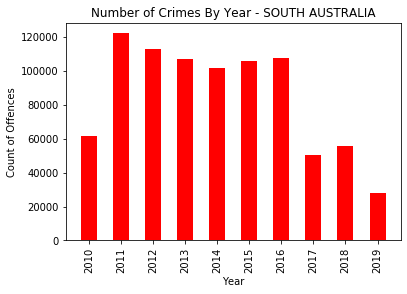

In [16]:
temp_count_y = crime_df.groupBy(year('Reported Date_').alias('year')).sum().withColumnRenamed('sum(Offence Count)','y_count').orderBy('Year').collect()
# plot
bar_width = 0.5
objects = [row['year'] for row in temp_count_y]
y_axis = [row['y_count'] for row in temp_count_y]
y_pos = np.arange(len(objects))

plt.bar(y_pos, y_axis, bar_width, align='center', color='r')
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Year')
plt.ylabel('Count of Offences')
plt.title('Number of Crimes By Year - SOUTH AUSTRALIA')
plt.show()

Explanation: The above bar chart shows the number of crimes in South Australia for nine years from the year 2010 to 2019. This graph shows the trend that the number of crimes are decreasing in the state.

## Number of crimes by months:

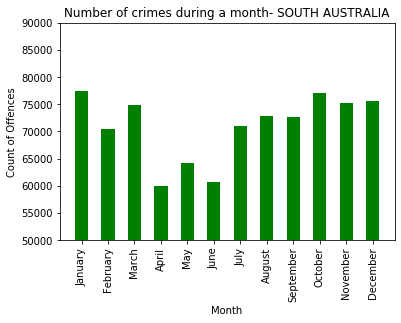

In [19]:
temp_count_m = crime_df.groupBy(month('Reported Date_').alias('month')).sum().withColumnRenamed('sum(Offence Count)','off_count').orderBy('Month').collect()


# plot
bar_width = 0.5
objects = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December')
y_axis = [row['off_count'] for row in temp_count_m]
y_pos = np.arange(len(objects))

plt.bar(y_pos, y_axis, bar_width, align='center', color='g')
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Month')
plt.ylabel('Count of Offences')
plt.title('Number of crimes during a month- SOUTH AUSTRALIA')
plt.ylim(50000, 90000)
plt.show()

Explanation: The above bar chart shows the number of criminal offences in different months of South Australia.

In [ ]:
# most crime took place

In [ ]:
# Number of serious trespasses by day and month

# temp_count_m = crime_df.groupBy(month('Reported Date_').alias('month')).sum().withColumnRenamed('sum(Offence Count)','off_count').orderBy('Month').collect()
# temp_count_d = crime_df.groupBy(dayofweek('Reported Date_').alias('dayofweek')).sum().withColumnRenamed('sum(Offence Count)','y_count').orderBy('DayOfweek').collect()


# bar_width = 0.5
# objects1 = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December')
# objects2 = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')
# y_axis1 = [row['off_count'] for row in temp_count_m]
# y_axis2 = [row['y_count'] for row in temp_count_d]
# y_pos = np.arange(len(objects))


# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)


# plt.bar(y_pos, y_axis1, bar_width, align='center', color='g')
# plt.xticks(y_pos, objects1, rotation='vertical')
# plt.xlabel('Month')
# plt.ylabel('Count of Offences')
# plt.title('Number of crimes during a month- SOUTH AUSTRALIA')

# plt.bar(y_pos, y_axis2, bar_width, align='center', color='g')
# plt.xticks(y_pos, objects2, rotation='vertical')
# plt.xlabel('Month')
# plt.ylabel('Count of Offences')
# plt.title('Number of crimes during a month- SOUTH AUSTRALIA')

# plt.plot()